# Кластеризация
__Суммарное количество баллов: 10__

__Решение отправлять на `ml.course.practice@gmail.com`__

__Тема письма: `[ML][MS][HW02] <ФИО>`, где вместо `<ФИО>` указаны фамилия и имя__

В этом домашнем задании предлагается реализовать три различных метода кластеризации, понять, в каких случаях стоит применять те или иные методы, а так же применить один из алгоритмов к задаче уменьшения цветности изображения.

In [1]:
import cv2
import copy
import scipy
import random
import warnings
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

from collections import deque
from typing import NoReturn

from sklearn.neighbors import KDTree
from sklearn.datasets import make_blobs, make_moons, make_swiss_roll

In [2]:
def visualize_clasters(X, labels):
    unique_labels = np.unique(labels)
    unique_colors = np.random.random((len(unique_labels), 3))
    colors = [unique_colors[int(l)] for l in labels]
    plt.figure(figsize=(9, 9))
    plt.scatter(X[:, 0], X[:, 1], c=colors)
    plt.show()

Генерируем два синтетических набора данных для кластеризации. Далее будем тестировать наши алгоритмы на них.

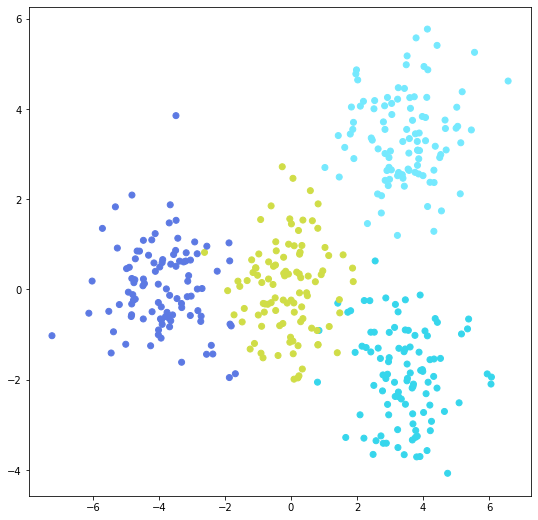

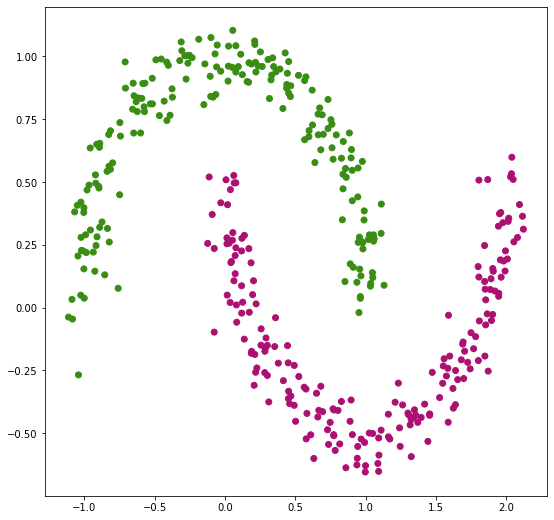

In [3]:
X_1, true_labels = make_blobs(400, 2, centers=[[0, 0], [-4, 0], [3.5, 3.5], [3.5, -2.0]], random_state=42)
visualize_clasters(X_1, true_labels)
X_2, true_labels = make_moons(400, noise=0.075, random_state=42)
visualize_clasters(X_2, true_labels)

### Задание 1 (3 балла)
Первый метод, который предлагается реализовать - метод K средних.

#### Описание методов
`fit(X, y=None)` ищет и запоминает в `self.centroids` центроиды кластеров для набора данных.
`predict(X)` для каждого элемента из `X` возвращает номер кластера, к которому относится данный элемент.

#### Инициализация кластеров
Есть несколько вариантов инициализации кластеров. Нужно реализовать их все:
1. `random` - центроиды кластеров являются случайными точками
2. `sample` - центроиды кластеров выбираются случайно из набора данных
3. `k-means++` - центроиды кластеров инициализируются при помощи метода K-means++

__Не забудте реинициализировать пустые кластеры!__

In [51]:
class KMeans:
    def __init__(self, n_clusters: int, init: str = "random", 
                 max_iter: int = 300):
        """
        Parameters
        ----------
        n_clusters : int
            Число итоговых кластеров при кластеризации.
        init : str
            Способ инициализации кластеров. Один из трех вариантов:
            1. random --- центроиды кластеров являются случайными точками,
            2. sample --- центроиды кластеров выбираются случайно из  X,
            3. k-means++ --- центроиды кластеров инициализируются 
                при помощи метода K-means++.
        max_iter : int
            Максимальное число итераций для kmeans.
        
        """
        self._inits = {"random": KMeans._random, "sample": KMeans._sample, "k-means++": KMeans._kmeans_pp}
        
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        
        self._init_clust = self._inits[init]
        self._centroids = None
        
    @staticmethod
    def distance(X, point):
        return np.sqrt(np.sum((X - point)**2, axis=1))
    
    @staticmethod
    def distance_matrix(X, Y, sqrt=False):      
        dists = np.sum(X**2, axis=1, keepdims=True) + np.sum(Y**2, axis=1) - 2*X @ Y.T
        if sqrt:
            return np.sqrt(np.around(dists, 12))
        return dists
            
    @staticmethod
    def _random(X, k):
        min_, max_ = X.min(axis=0), X.max(axis=0) 
        
        return np.random.uniform(min_, max_, size=(k, X.shape[1]))
    
    @staticmethod
    def _sample(X, k):
        idxs = np.random.choice(X.shape[0], size=k)
        
        return X[idxs]
    
    @staticmethod
    def _kmeans_pp(X, k):
        n_samples, n_features = X.shape
        centers = np.zeros((k, n_features))

        centers[0] = X[np.random.choice(n_samples)]
        dist_to_centers = KMeans.distance(X, centers[0])
        
        for i in range(1, k):
            sqrd_dist = dist_to_centers**2
        
            centers[i] = X[np.random.choice(n_samples, 1, p=sqrd_dist / np.sum(sqrd_dist))]
            new_dist = KMeans.distance(X, centers[i])

            dist_to_centers = np.minimum(dist_to_centers, new_dist)

        return centers
            

    def fit(self, X: np.array, y = None) -> NoReturn:
        """
        Ищет и запоминает в self.centroids центроиды кластеров для X.
        
        Parameters
        ----------
        X : np.array
            Набор данных, который необходимо кластеризовать.
        y : Ignored
            Не используемый параметр, аналогично sklearn
            (в sklearn считается, что все функции fit обязаны принимать 
            параметры X и y, даже если y не используется).
        
        """
        self._centroids = self._init_clust(X, self.n_clusters)
        
        prev_labels = np.zeros(X.shape[0])
        for i in range(self.max_iter):
            dists = KMeans.distance_matrix(X, self._centroids)
            
            labels = np.argmin(dists, axis=1)
            
            if np.all(labels == prev_labels):
                break
            
            for cluster in range(self.n_clusters):
                cluster_idx = (labels == cluster)

                if np.sum(cluster_idx) > 0:
                    self._centroids[cluster] = np.mean(X[cluster_idx], axis=0)
                    
            prev_labels = labels
                    
        return self
    
    def predict(self, X: np.array) -> np.array:
        """
        Для каждого элемента из X возвращает номер кластера, 
        к которому относится данный элемент.
        
        Parameters
        ----------
        X : np.array
            Набор данных, для элементов которого находятся ближайшие кластера.
        
        Return
        ------
        labels : np.array
            Вектор индексов ближайших кластеров 
            (по одному индексу для каждого элемента из X).
        
        """
        if self._centroids is None:
            raise AttributeError("This KMeans instance is not fitted yet. Call 'fit' before using this method")
        
        return np.argmin(KMeans.distance_matrix(X, self._centroids), axis=1)

Протестируйте алгоритм на синтетических данных. При необходимости подберите гиперпараметры для достижения лучшего качества кластеризации.

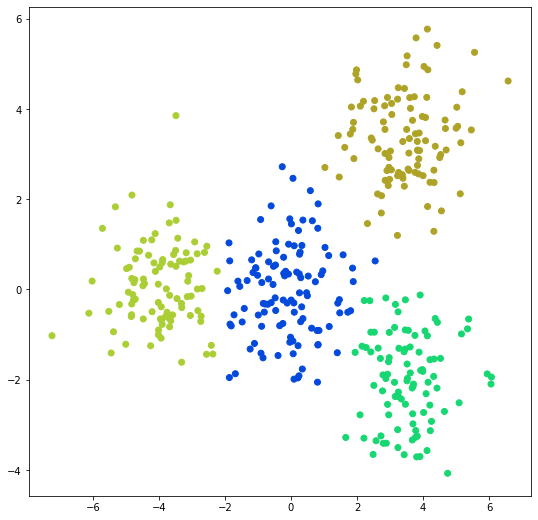

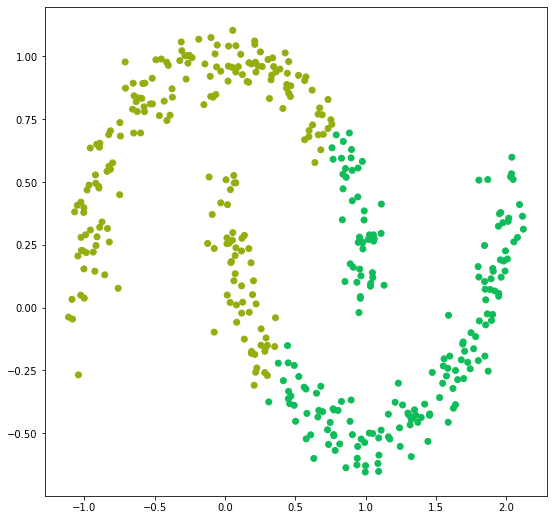

In [52]:
kmeans = KMeans(init="k-means++", n_clusters=4)
kmeans.fit(X_1)
labels = kmeans.predict(X_1)
visualize_clasters(X_1, labels)

kmeans = KMeans(init="k-means++", n_clusters=2)
kmeans.fit(X_2)
labels = kmeans.predict(X_2)
visualize_clasters(X_2, labels)

### Задание 2 (2 балла)
В отличии от K-means, DBScan не позволяет задать количество кластеров, на которое будут разбиты данные. Руководствуясь геометрической интерпретацией, он позволяет выделять кластеры более сложной формы.

#### Описание методов
`fit_predict(X, y=None)` для каждого элемента `X` возвращает метку кластера, к которому он относится.

#### Возможные метрики
* `euclidean`
* `manhattan`
* `chebyshev`

__Для быстрого поиска соседей используйте `sklearn.neighbors.KDTree`__

In [53]:
class DBScan:
    def __init__(self, eps: float = 0.5, min_samples: int = 5, 
                 leaf_size: int = 40, metric: str = "euclidean"):
        """
        
        Parameters
        ----------
        eps : float, min_samples : int
            Параметры для определения core samples.
            Core samples --- элементы, у которых в eps-окрестности есть 
            хотя бы min_samples других точек.
        metric : str
            Метрика, используемая для вычисления расстояния между двумя точками.
            Один из трех вариантов:
            1. euclidean 
            2. manhattan
            3. chebyshev
        leaf_size : int
            Минимальный размер листа для KDTree.

        """
        self.eps = eps
        self.min_samples = min_samples
        self.leaf_size = leaf_size
        self.metric = metric        
        
    def fit_predict(self, X: np.array, y = None) -> np.array:
        """
        Кластеризует элементы из X, 
        для каждого возвращает индекс соотв. кластера.
        Parameters
        ----------
        X : np.array
            Набор данных, который необходимо кластеризовать.
        y : Ignored
            Не используемый параметр, аналогично sklearn
            (в sklearn считается, что все функции fit_predict обязаны принимать 
            параметры X и y, даже если y не используется).
        Return
        ------
        labels : np.array
            Вектор индексов кластеров
            (Для каждой точки из X индекс соотв. кластера).

        """
        kd_tree = KDTree(X, leaf_size=self.leaf_size, metric=self.metric)
        
        all_neighbors = kd_tree.query_radius(X, self.eps)
        labels, cluster = -np.ones(X.shape[0]), 0
        
        for idx, point in enumerate(X):
            if labels[idx] != -1:
                continue
            
            neighs = deque(all_neighbors[idx])
            
            if len(neighs) <= self.min_samples:
                continue
            
            # wait, thats a bfs!!
            labels[idx] = cluster
            
            while neighs:
                neigh = neighs.pop()
                
                if neigh == idx or labels[neigh] != -1:
                    continue
                
                labels[neigh] = cluster
                new_neighs = all_neighbors[neigh]
                
                if new_neighs.shape[0] > self.min_samples:
                    neighs.extendleft(new_neighs)
            
            cluster = cluster + 1
                
        labels[labels == -1] = cluster
                
        return labels

Протестируйте алгоритм на синтетических данных. При необходимости подберите гиперпараметры для достижения лучшего качества кластеризации.

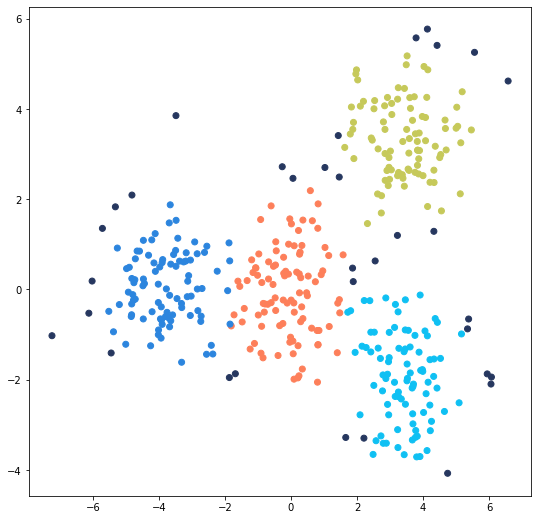

CPU times: user 681 ms, sys: 36 ms, total: 717 ms
Wall time: 867 ms


In [54]:
%%time
dbscan = DBScan(eps=0.9, min_samples=15)
labels = dbscan.fit_predict(X_1)
visualize_clasters(X_1, labels)

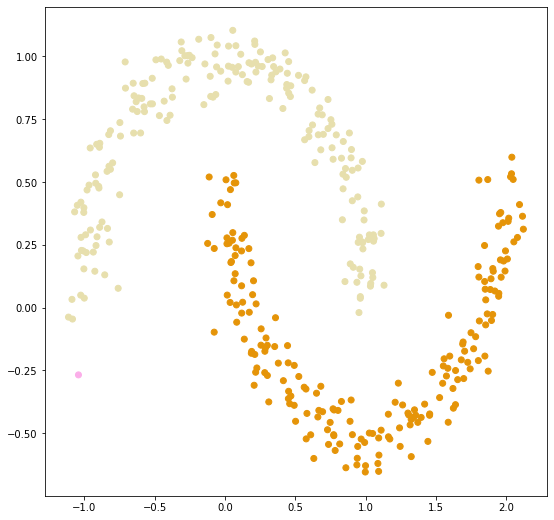

CPU times: user 566 ms, sys: 22.5 ms, total: 589 ms
Wall time: 625 ms


In [55]:
%%time
dbscan = DBScan(eps=0.2, min_samples=10)
labels = dbscan.fit_predict(X_2)
visualize_clasters(X_2, labels)

### Задание 3 (3 балла)
Идея AgglomerativeClustering заключается в том, чтобы итеративно объединять кластеры с наименьшим расстоянием между ними. Данный метод обладает высокой вычислительной сложностью, поэтому применим только для относительно небольших наборов данных.

#### Описание методов
`fit_predict(X, y=None)` для каждого элемента `X` возвращает метку кластера, к которому он относится.

#### Linkage-функции
__Linkage__ - это способ, которым будет рассчитываться расстояние между кластерами. Предлагается реализовать три варианта такой функции:
1. `average` - расстояние рассчитывается как среднее расстояние между всеми парами точек, где одна принадлежит первому кластеру, а другая - второму.
2. `single` - расстояние рассчитывается как минимальное из расстояний между всеми парами точек, где одна принадлежит первому кластеру, а другая - второму.
2. `complete` - расстояние рассчитывается как максимальное из расстояний между всеми парами точек, где одна принадлежит первому кластеру, а другая - второму.

In [56]:
def map_to_range(labels):
    counter = -1
    index = {}
    
    for i, label in enumerate(labels):
        if label not in index:
            counter = counter + 1
            index[label] = counter
        labels[i] = index[label]
            

class AgglomertiveClustering:
    def __init__(self, n_clusters: int = 16, linkage: str = "single"):
        """
        
        Parameters
        ----------
        n_clusters : int
            Количество кластеров, которые необходимо найти (то есть, кластеры 
            итеративно объединяются, пока их не станет n_clusters)
        linkage : str
            Способ для расчета расстояния между кластерами. Один из 3 вариантов:
            1. average --- среднее расстояние между всеми парами точек, 
               где одна принадлежит первому кластеру, а другая - второму.
            2. single --- минимальное из расстояний между всеми парами точек, 
               где одна принадлежит первому кластеру, а другая - второму.
            3. complete --- максимальное из расстояний между всеми парами точек,
               где одна принадлежит первому кластеру, а другая - второму.
        """ 
        self._linkage = {
            # https://en.wikipedia.org/wiki/WPGMA - проще, но от тех же авторов что и average
            "average": lambda arr1, arr2: np.nanmean([arr1, arr2], axis=0), 
            "single": np.fmin, 
            "complete": np.fmax
        }
        
        assert n_clusters > 0, "number of clusters should be non-zero"
        self.n_clusters = n_clusters
        
        self.distance = self._linkage[linkage]
        self.linkage = linkage
    
    @staticmethod
    def get_minimum(dist_matrix):
        i, j = np.unravel_index(
            np.nanargmin(dist_matrix),
            shape=dist_matrix.shape
        )
        return i, j
    
    
    def update_distance(self, index, dist_matrix):
        i, j = index
        
        with warnings.catch_warnings():
            # RuntimeWarning: Mean of empty slice, but its okay
            warnings.simplefilter("ignore", category=RuntimeWarning)
            new_clust_dist = self.distance(dist_matrix[i, :], dist_matrix[j, :])
        
        dist_matrix[i, :] = new_clust_dist
        dist_matrix[:, i] = new_clust_dist
        
        dist_matrix[j, :] = np.nan
        dist_matrix[:, j] = np.nan
        np.fill_diagonal(dist_matrix, np.nan)
        
        
    def distance_matrix(self, X, Y):       
        dists = np.sum(X**2, axis=1, keepdims=True) + np.sum(Y**2, axis=1) - 2*X @ Y.T
        dists = np.sqrt(np.around(dists, 12))
        np.fill_diagonal(dists, np.nan)
        
        return dists
    
        
    def fit_predict(self, X: np.array, y = None) -> np.array:
        """
        Кластеризует элементы из X, 
        для каждого возвращает индекс соотв. кластера.
        Parameters
        ----------
        X : np.array
            Набор данных, который необходимо кластеризовать.
        y : Ignored
            Не используемый параметр, аналогично sklearn
            (в sklearn считается, что все функции fit_predict обязаны принимать 
            параметры X и y, даже если y не используется).
        Return
        ------
        labels : np.array
            Вектор индексов кластеров
            (Для каждой точки из X индекс соотв. кластера).

        """
        if X.shape[0] < self.n_clusters:
            raise ValueError(f"Not enough data to split on {self.n_clusters} clusters")
        
        labels = np.arange(X.shape[0])
        dists = self.distance_matrix(X, X)

        clusters = X.shape[0] - 1
        
        while clusters >= self.n_clusters:
            i, j = self.get_minimum(dists)

            labels[labels == j] = i      
            
            self.update_distance((i, j), dists)
            clusters = clusters - 1

        map_to_range(labels)
        
        return labels

Протестируйте алгоритм на синтетических данных. При необходимости подберите гиперпараметры для достижения лучшего качества кластеризации.

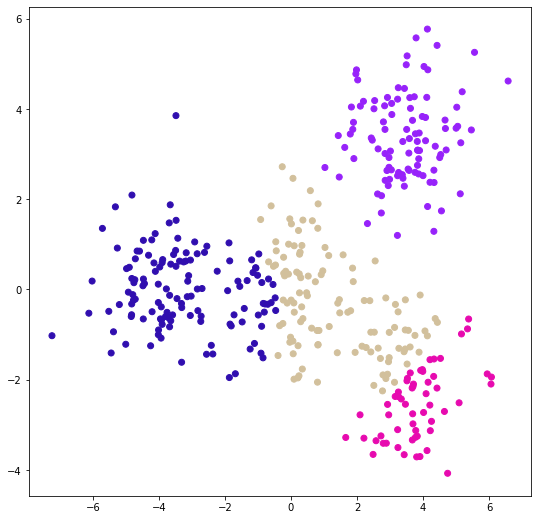

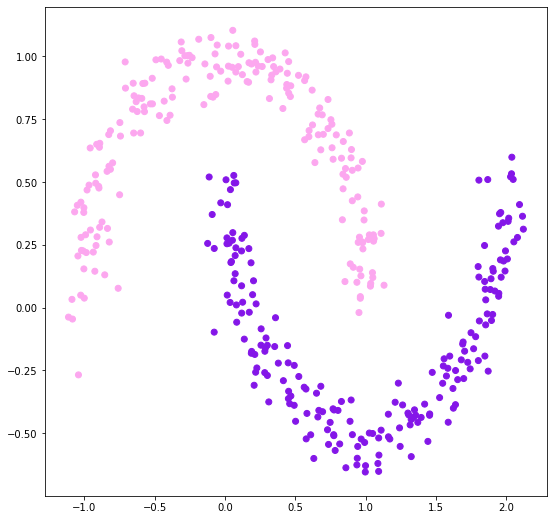

CPU times: user 1.82 s, sys: 83.1 ms, total: 1.9 s
Wall time: 1.91 s


In [57]:
%%time
agg_clustering = AgglomertiveClustering(linkage="complete", n_clusters=4)
labels = agg_clustering.fit_predict(X_1)
visualize_clasters(X_1, labels)

agg_clustering = AgglomertiveClustering(linkage="single", n_clusters=2)
labels = agg_clustering.fit_predict(X_2)
visualize_clasters(X_2, labels)

### Задание 4 (1 балл)
Реализуйте методы считывания и записи изображения при помощи библиотеки OpenCV. 

#### Описание методов
`read_image(path)` читает изображение и возвращает его в виде трехмерного numpy массива размера `(N, M, C)`, где `N` и `M` - размеры изображения, а `C` - количество цветов (3 для обычного изображения)
`save_image(image, path)` сохраняет изображение.

__Учтите, что `cv2.imread` считывает изображение в цветовой схеме BGR. После считывания необходимо перевести его в RGB и нормализовать__

In [58]:
def read_image(path: str) -> np.array:
    """
    Читает изображение.

    Parameters
    ----------
    path : str
        Путь к изображению.
    
    Return
    ------
    image : np.array
        Трехмерный массив размера (N, M, C), 
        где N и M - размеры изображения, 
        а C - количество цветов (3 для обычного изображения).
    """
    image = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
    
    return cv2.normalize(image, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_64F)
    

def show_image(image: np.array) -> NoReturn:
    """
    Выводит изображение

    Parameters
    ----------
    image : np.сarray
        Трехмерный массив - нормализованное изображение в цветовой схеме RGB.
    """
    plt.figure(figsize=np.array(image.shape[:-1]) / 50)
    plt.imshow(image)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

def save_image(image: np.array, path: str) -> NoReturn:
    """
    Сохраняет изображение.

    Parameters
    ----------
    image : np.array
        Трехмерный массив - нормализованное изображение в цветовой схеме RGB.
    path : str
        Путь для сохранения.
    """
    image = cv2.normalize(image, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    
    cv2.imwrite(path, cv2.cvtColor(image, cv2.COLOR_RGB2BGR))

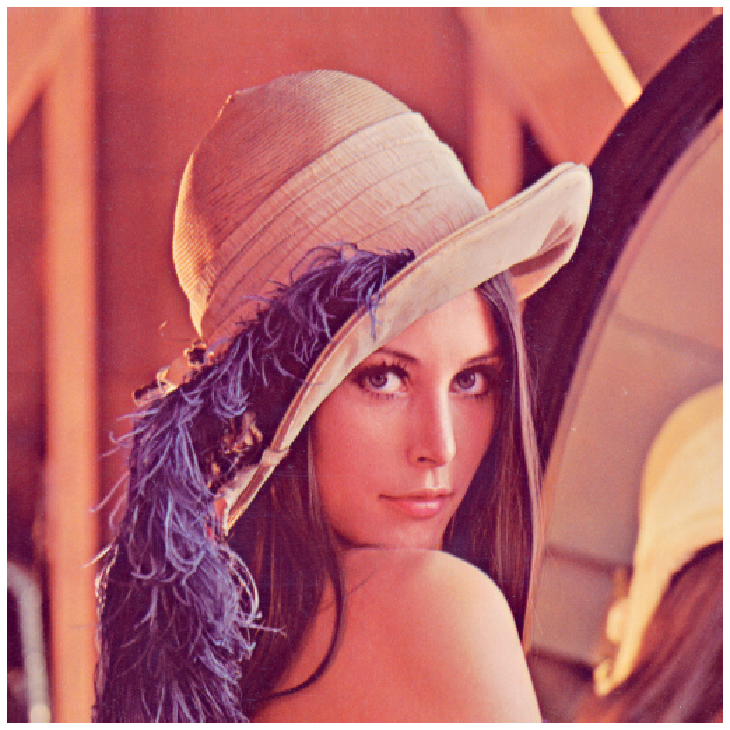

In [59]:
show_image(read_image("old_classic.png"))

### Задание 5 (1 балл)
Реализуйте функцию, которая будет кластеризовать цвета изображения одним из реализованных алгоритмов. Интерфейс этой функции можно менять. Функция должна возвращать новое изображение, в котором цвета заменены на цвета кластеров.

Затем примените ее к цветам изображения.

__Примечание: это задание проще всего выполнить при помощи KMeans__

In [60]:
class ColorCompressor:
    def __init__(self, n_colors, **kwargs):
        self.kmeans = KMeans(n_clusters=n_colors, **kwargs)
        
    @staticmethod
    def clusters_statistics(flat_img, cluster_colors, cluster_labels, plot_frac):
        fig, axes = plt.subplots(3, 2, figsize=(16, 20))

        sample_idx = np.random.choice(flat_img.shape[0], int(flat_img.shape[0] * plot_frac), replace=False)
        sampled_img = flat_img[sample_idx]
        sampled_labels = cluster_labels[sample_idx]

        for remove_color in range(3):
            axes_pair = axes[remove_color]
            first_color = 0 if remove_color != 0 else 2
            second_color = 1 if remove_color != 1 else 2

            axes_pair[0].scatter(sampled_img[:, first_color], sampled_img[:, second_color], c=sampled_img, marker=".")
            axes_pair[1].scatter(sampled_img[:, first_color], sampled_img[:, second_color], 
                                 c=cluster_colors[sampled_labels], marker='.')

            for a in axes_pair:
                a.set_xlim(0, 1)
                a.set_ylim(0, 1)

        for ax, title in zip(axes[0], ["Image Pixels", "Clustered Pixels"]):
            ax.set_title(title)

        plt.show()
        
    @staticmethod
    def _recolor_image(image, pred_clusters):
        clusters = np.unique(pred_clusters)
        colors = np.zeros((clusters.shape[0], image.shape[1]))

        recolored_image = np.copy(image)
        for i, clust in enumerate(clusters):
            idxs = (pred_clusters == clust)

            colors[i] = np.mean(image[idxs], axis=0)
            recolored_image[idxs] = colors[i]

        return recolored_image, colors
        
    def compress_image(self, image, show_stats=False, plot_fraq=0.1):
        data = image.reshape(-1, 3)
        
        self.kmeans.fit(data)
        clusters = self.kmeans.predict(data)
        recolored, cluster_colors = self._recolor_image(data, clusters)
        
        if show_stats:
            self.clusters_statistics(image.reshape(-1, 3), cluster_colors, clusters, plot_fraq)
            
        return recolored.reshape(*image.shape)
    
    def compress_from_path(self, path, show_stats=True, plot_fraq=0.1):
        image = read_image(path)
        recolored_image = self.compress_image(image, show_stats, plot_fraq)

        return recolored_image

In [61]:
compressor = ColorCompressor(n_colors=5, init="k-means++")

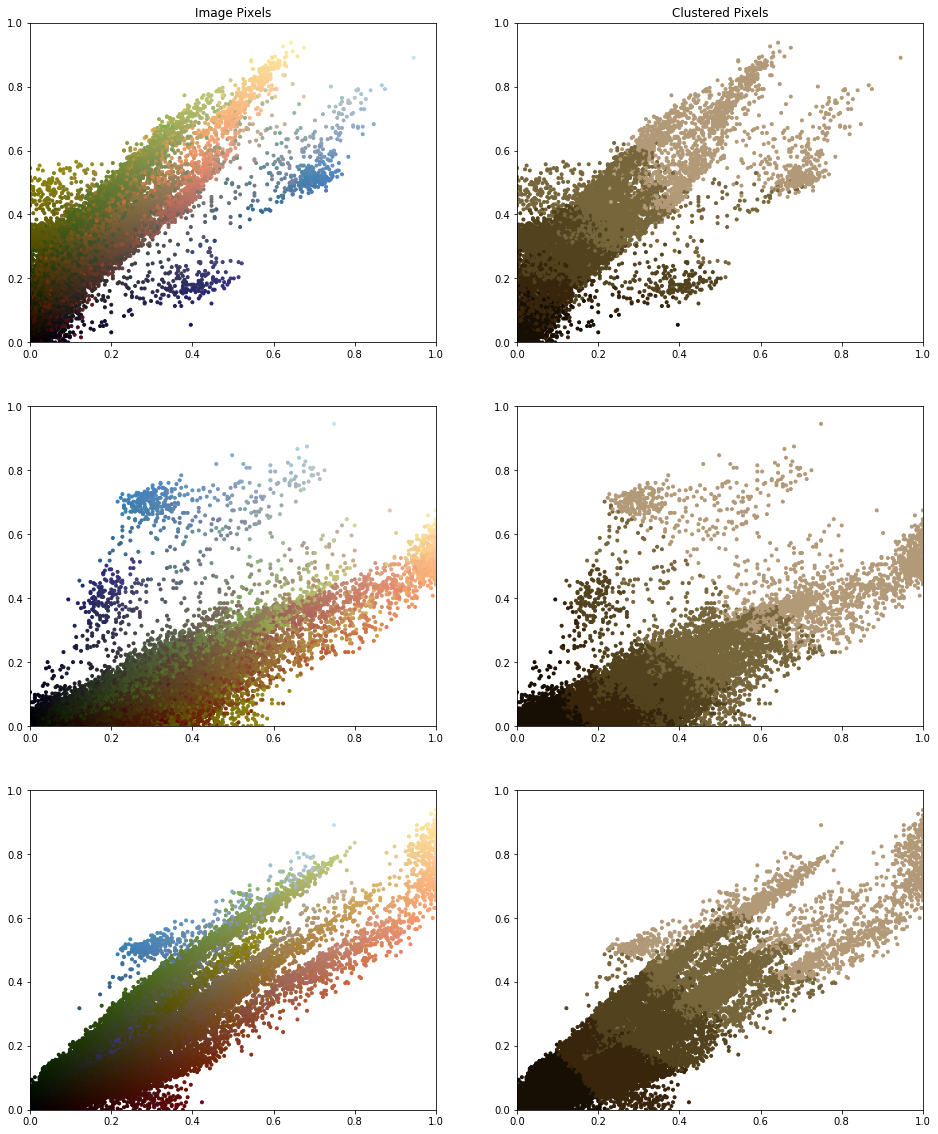

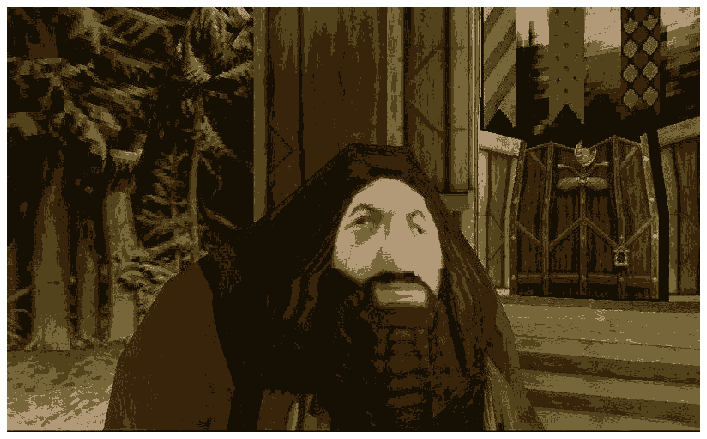

CPU times: user 17.2 s, sys: 1.17 s, total: 18.4 s
Wall time: 16.4 s


In [62]:
%%time
show_image(compressor.compress_from_path("hagrid.jpg"))

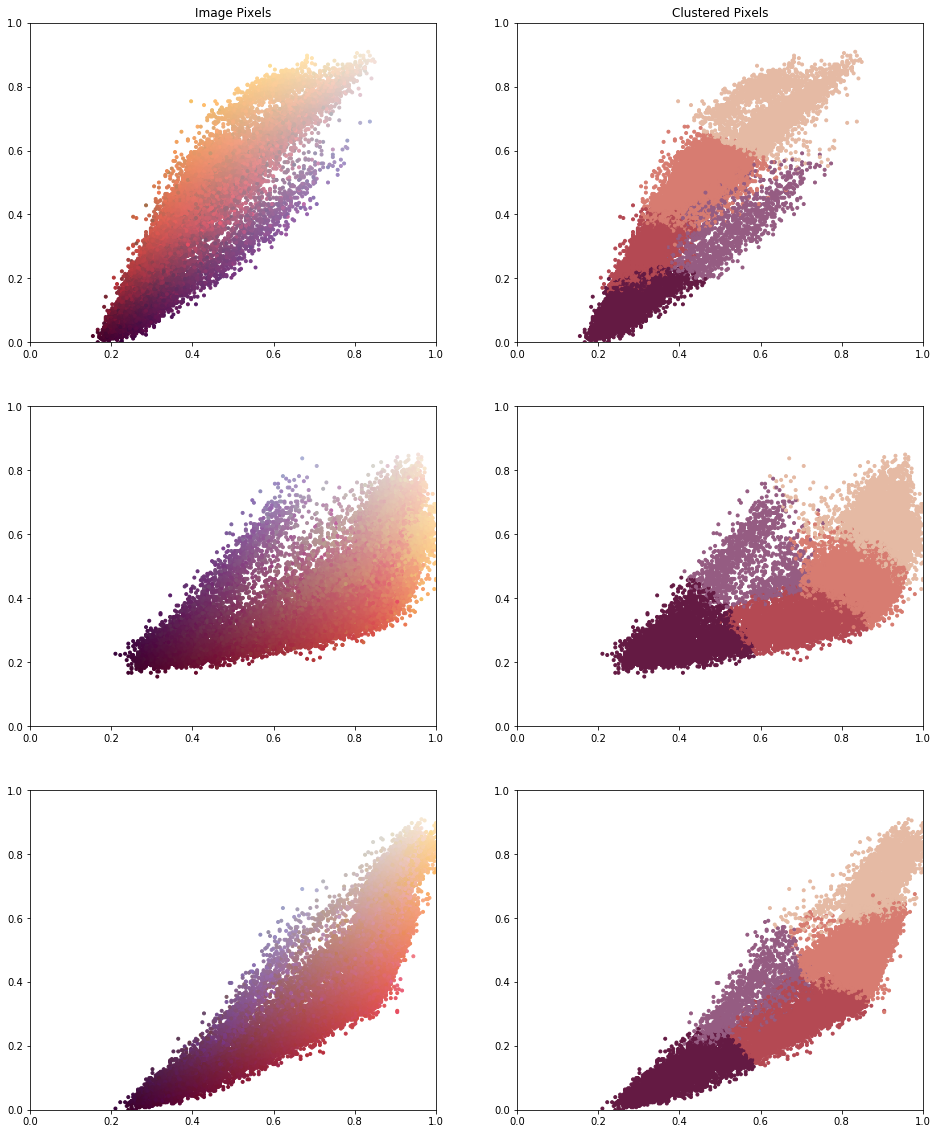

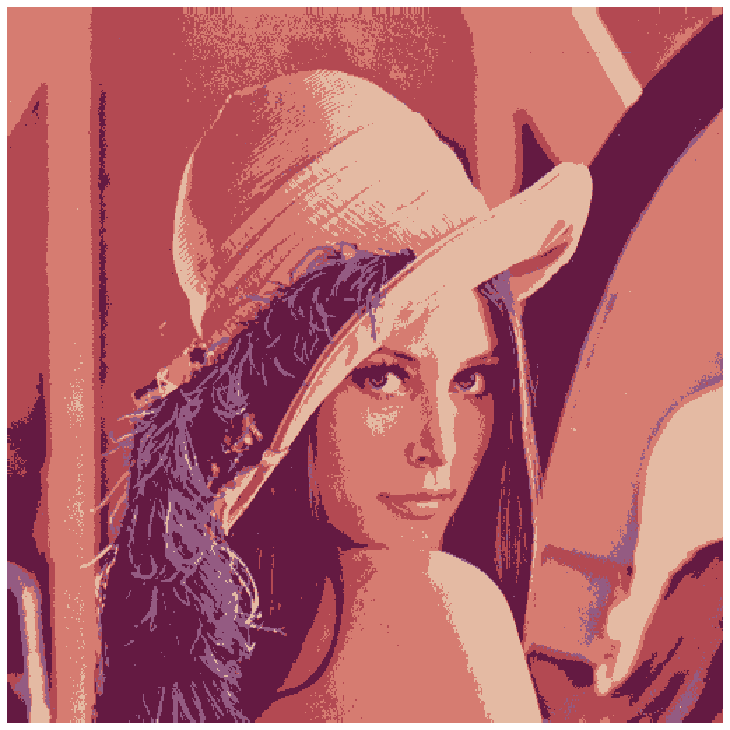

CPU times: user 11.3 s, sys: 763 ms, total: 12 s
Wall time: 10.5 s


In [63]:
%%time
show_image(compressor.compress_from_path("old_classic.png"))

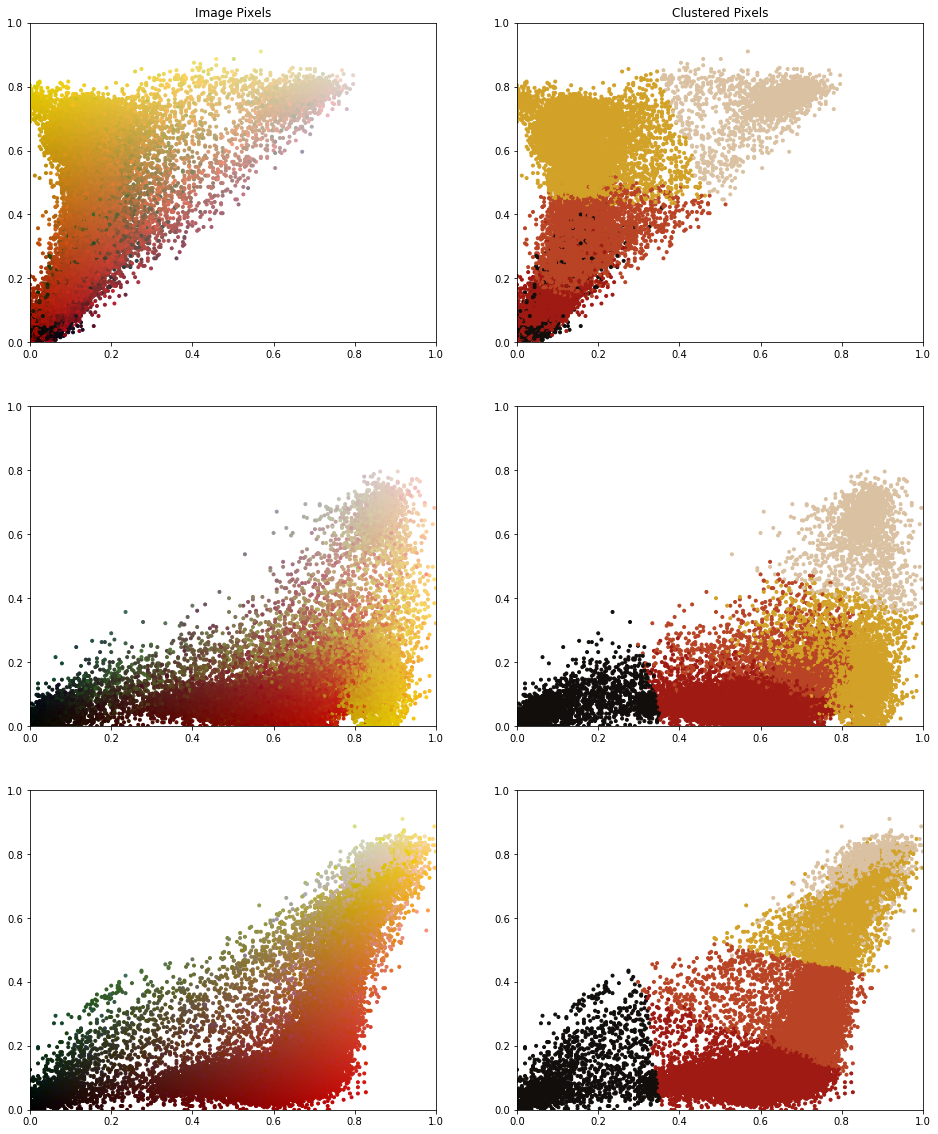

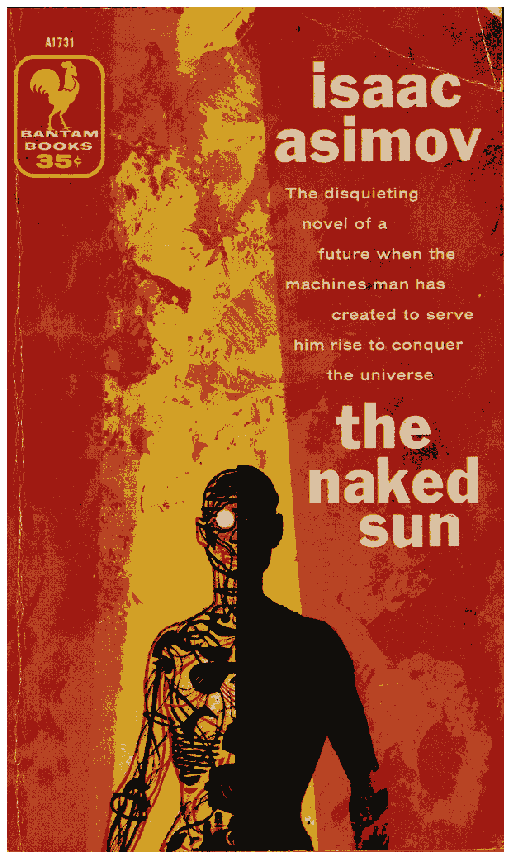

CPU times: user 25.3 s, sys: 1.44 s, total: 26.7 s
Wall time: 34.8 s


In [64]:
%%time
show_image(compressor.compress_from_path("asimov.jpg"))